In [61]:
import torch
import cv2
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import beta
import scipy.ndimage as ndimage
from scipy.signal.windows import gaussian
from dstft import ADSTFT, ADSTFTenergy2, DSTFTabs
import torch
import torch.nn as nn

%load_ext autoreload
%autoreload 2
%matplotlib inline

from dstft import DSTFTdev, DSTFT, DSTFTabs, DSTFTenergy

device = "cpu" # "cuda" if torch.cuda.is_available() else "cpu"
#device = torch.device("mps")
print(device, torch.__version__)
torch.manual_seed(1802)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cpu 2.6.0


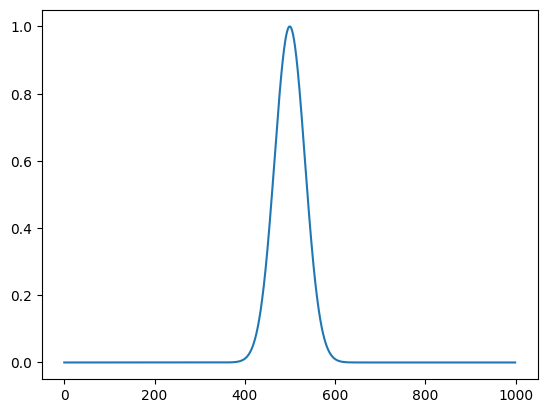

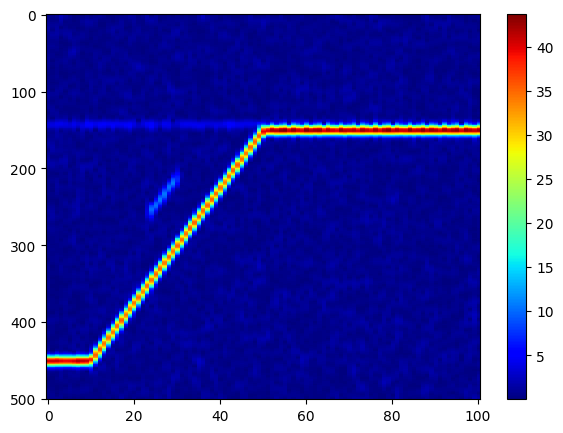

AttributeError: module 'cv2' has no attribute 'ximgproc'

In [83]:
mat = loadmat("../data/fan_flutter.mat")["x"]
#x = torch.from_numpy(mat).float().to(device)[:, 4_000:10_000]
x = mat[:, 4_000:10_000].flatten()

import time
tic_time = None
def tic():
    global tic_time
    tic_time = time.time()
def toc(print_elapsed=True):
    global tic_time
    elapsed = time.time() - tic_time
    if print_elapsed:
        print(f"Elapsed time: {elapsed:.4f} seconds")
    return elapsed

def gaussian_window(length, sigma):
    n = np.arange(length) - (length - 1) / 2
    window = np.exp(-0.5 * (n / sigma)**2)
    return window / np.max(window)  # Normalize the window

def beta_window(length, width):
    alpha = 1/2* ( (3000/width)**2 -1 )
    n = np.arange(length) - (length - 1) / 2  # Center the window
    # Rescale the n values to the range [0, 1]
    n = (n / (length - 1)) + 0.5
    # Calculate the Beta distribution for each value of n
    window = (n ** (alpha - 1)) * ((1 - n) ** (alpha - 1))
    # Normalize the window
    window = window / np.max(window)
    return window

def pad_image(image, pad_width):
    # Pad the image by repeating the left and right edges
    padded_image = np.pad(image, ((0, 0), (pad_width, pad_width)), mode='edge')
    return padded_image

def window_signal_from_index(x, index, window):
    signal_slice = x[index : index+len(window)]
    windowed_signal = signal_slice * window
    return windowed_signal

length = 1000
width = 200
stride = 50
sigma = width /6
gauss = beta_window(length, width)  #gaussian_window(length, sigma)
gauss_1 = np.concatenate([[0], np.diff(gauss)])
gauss_2 = np.concatenate([np.diff(gauss_1), [0]])
gauss_3 = np.concatenate([[0], np.diff(gauss_2)])

all_diffs = []
for diff in [gauss]:
    plt.plot(diff)
    plt.show()
    index = 0
    diff_vals = []
    while index +len(diff) <= len(x):
        windowed_signal = window_signal_from_index(x, index, diff)
        fft = np.fft.fft(windowed_signal)
        diff_vals.append(fft)
        index += stride
    diff_vals = np.array(diff_vals)
    diff_vals = np.abs(diff_vals)
    diff_vals = np.array(diff_vals).T
    #diff_vals = np.log(diff_vals)
    diff_vals = diff_vals[499:, :]
    plt.figure(figsize=[7, 5])
    plt.imshow(diff_vals, cmap='jet', aspect='auto', interpolation='nearest')
    plt.colorbar()
    plt.show()

    diff_vals = diff_vals.astype(float)
    #sigma = 2
    #kernel_size = (0, 0)
    #smoothed_image = cv2.GaussianBlur(diff_vals, kernel_size, sigmaX=sigma, sigmaY=0)
    #smoothed_image = cv2.medianBlur(diff_vals, ksize=5)  # ?
    #smoothed_image = cv2.bilateralFilter(diff_vals, d=9, sigmaColor=75, sigmaSpace=75)
    smoothed_image = cv2.ximgproc.guidedFilter(guide=diff_vals, src=diff_vals, radius=8, eps=0.01*255**2)
    plt.figure(figsize=[7, 5])
    plt.imshow(smoothed_image, cmap='jet', aspect='auto', interpolation='nearest')
    plt.colorbar()
    plt.show()

    left_right_derivative = np.diff(smoothed_image, axis=1, append=smoothed_image[:, -1:])
    plt.figure(figsize=[7, 5])
    plt.imshow(left_right_derivative, cmap='jet', aspect='auto', interpolation='nearest')
    plt.colorbar()
    plt.show()

    left_right_2nd_derivative = np.abs(np.diff(left_right_derivative, axis=1, append=left_right_derivative[:, -1:]))
    plt.figure(figsize=[7, 5])
    plt.imshow(left_right_2nd_derivative, cmap='jet', aspect='auto', interpolation='nearest')
    plt.colorbar()
    plt.show()

    derivsum = np.abs(left_right_derivative)+np.abs(left_right_2nd_derivative)
    plt.figure(figsize=[7, 5])
    plt.imshow(derivsum, cmap='jet', aspect='auto', interpolation='nearest')
    plt.colorbar()
    plt.show()

    good_window_length = 1/(np.abs(left_right_derivative)+1e-7)
    good_window_length = 200*good_window_length
    good_window_length[good_window_length < 100] = 100
    good_window_length[good_window_length > 1000] = 1000
    plt.figure(figsize=[7, 5])
    plt.imshow(good_window_length, cmap='jet', aspect='auto', interpolation='nearest')
    plt.colorbar()
    plt.show()

    sigma = 1
    smoothed_window_length = cv2.GaussianBlur(good_window_length, kernel_size, sigma)
    plt.figure(figsize=[7, 5])
    plt.imshow(smoothed_window_length, cmap='jet', aspect='auto', interpolation='nearest')
    plt.colorbar()
    plt.show()

    #export_window_length = pad_image(smoothed_window_length, length//(2*stride))

    print(np.min(good_window_length), np.max(good_window_length))
    print(np.min(smoothed_window_length), np.max(smoothed_window_length))
    #print(export_window_length.shape)
    
    all_diffs.append(diff_vals)

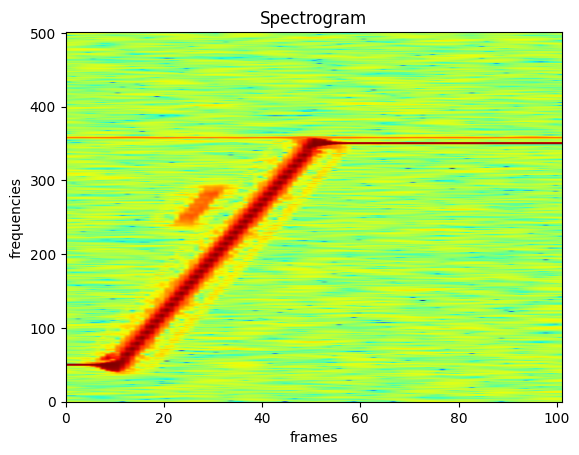

/Users/kaspernordenram/Desktop/Skola/LTH/Mitt år 5/FMSN35/Projekt/projekt-fmsn35/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


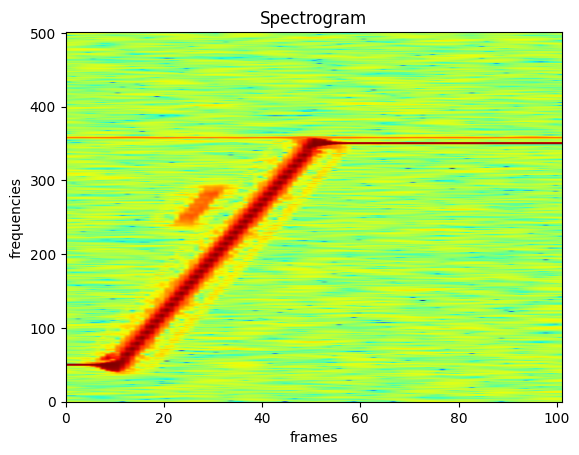

KeyboardInterrupt: 

In [74]:

flipped_image = smoothed_window_length[::-1]  # smoothed_window_length
flipped_lengths_copy = flipped_image.copy()
filled = np.full((499, flipped_lengths_copy.shape[1]), 500)
combined_image = np.vstack([flipped_lengths_copy, filled])
all_lengths = combined_image
x = torch.from_numpy(mat).float().to(device)[:, 4_000:10_000]
window_length_tensor = torch.tensor(all_lengths, dtype=torch.float32)  # torch.tensor(export_window_length, dtype=torch.float32)
adstft = DSTFTdev(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100)
adstft.win_length = nn.Parameter(window_length_tensor)
spec, *_ = adstft(x)
#adstft.plot(spec, weights=False, wins=False)
adstft.print(spec, weights=False, wins=False)

params = [{'params': adstft.win_length,'lr': 100.0}] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

def entropy_loss(x):
    x1 = torch.reshape(x, (x.shape[0], -1))  # B, N
    probs = torch.div(x1.T, x1.sum(dim=-1)).T  # B, N
    entropy = -(
        probs * torch.clamp(torch.log(probs), min=torch.finfo(x.dtype).min)
    ).sum(
        dim=-1,
    )  # B
    return entropy.mean()

def closure():
    opt.zero_grad()
    spec, *_ = adstft(x)
    err = entropy_loss(spec) + 0.01 * (adstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + adstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    return err

for epoch in range(1_000):
    opt.zero_grad()
    #spec, *_ = adstft.abs_forward(x)
    spec, *_ = adstft(x)
    err = entropy_loss(spec) + 0.01 * (adstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + adstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    #closure()
    #opt.step(closure)
    #sch.step(closure())

    if epoch % 10 == 0:
        #adstft.plot(spec, weights=False, wins=False)
        adstft.print(spec, weights=False, wins=False)
    
    if opt.param_groups[0]['lr'] < 1:
        break